In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import os
import re
from typing import List, Tuple, Dict, Any, Union # Added for better type hinting

# Import your constants module
import idd_climate_models.constants as rfc

# ============================================================================
# 1. CONSTANTS AND UTILITY FUNCTIONS
# ============================================================================

# --- Core Constants from rfc ---
# Define the core constants used in this script
MODELS_TO_RUN = ['ACCESS-CM2', 'EC-Earth3', 'EC-Earth3-Veg','EC-Earth3-Veg-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']
BIN_SIZE_YEARS = 20
DATA_SOURCE = "cmip6"
ssp_scenario_map = rfc.ssp_scenario_map
FUTURE_SCENARIOS = [s for s in ssp_scenario_map if s != 'historical']
NUM_DRAWS = 25
basin_dict = rfc.basin_dict
BASINS = [b for b in basin_dict if basin_dict[b]['most_detailed']]
VARIANT = 'r1i1p1f1' 

# Constants derived from rfc
TC_RISK_OUTPUT_PATH = rfc.TC_RISK_OUTPUT_PATH
THRESHOLD_DICT = rfc.threshold_dict # Renamed to uppercase for standard constant naming
TC_RISK_DATE_RANGES = rfc.build_tc_risk_date_ranges()
TIMESTEPS_PER_DAY = rfc.tc_time_steps_per_day


# Pre-calculate all time bins (This is efficient and kept)
TIME_BINS: Dict[str, List[Tuple[int, int]]] = {
    scenario: rfc.get_time_periods(scenario, BIN_SIZE_YEARS)
    for scenario in ssp_scenario_map
}

In [2]:
def get_output_dir(model: str, scenario: str, time_period: Tuple[int, int]) -> Path:
    """Constructs the parent directory for a time bin."""
    # Simplified Path construction
    time_period_str = f'{time_period[0]}-{time_period[1]}'
    return TC_RISK_OUTPUT_PATH / DATA_SOURCE / model / VARIANT / scenario / time_period_str

def get_track_path(model: str, scenario: str, time_period: Tuple[int, int], basin: str, draw: int) -> Path:
    """Constructs the full file path for a track file."""
    output_dir_parent = get_output_dir(model, scenario, time_period)
    
    # Draws are 1-based, array indices are 0-based (e.g., draw 1 is _e0)
    draw_text = f'_e{draw - 1}' if draw > 0 else ''
    
    # Use f-strings for time strings, ensuring 4-digit years
    time_start_str = f'{time_period[0]:04d}01' # Added :04d for explicit 4-digit formatting
    time_end_str = f'{time_period[1]:04d}12'
    
    # File name construction
    track_file = f'tracks_{basin}_{model}_{scenario}_{VARIANT}_{time_start_str}_{time_end_str}{draw_text}.nc'
    
    # The basin directory is a subdirectory of the time_period directory
    return output_dir_parent / basin / track_file

In [3]:

def process_track_file(file_path: Path, model: str, scenario: str, 
                       basin: str, draw: int, threshold_dict: Dict[str, Dict[str, Any]]) -> List[Dict[str, Union[str, int, float]]]:
    results = []
    
    try:
        # Use a context manager to ensure the file is closed
        with xr.open_dataset(file_path) as ds:
            
            # Extract and validate required data
            vmax_trks = ds['vmax_trks'].values  # Shape: (n_trk, time)
            tc_years = ds['tc_years'].values    # Shape: (n_trk) 
            
            # 1. Pre-calculate track maximum Vmax
            # np.nanmax handles NaNs correctly
            track_max_vmax = np.nanmax(vmax_trks, axis=1)

            # Loop over all thresholds
            for threshold_key, threshold_data in threshold_dict.items():
                threshold_value = threshold_data['wind_speed']

                # 2. Identify tracks that ever exceed the threshold (boolean array)
                exceeds_threshold = track_max_vmax >= threshold_value
                
                # Identify unique years present in the dataset (exclude NaNs)
                # Use np.unique and mask in one step
                unique_years = np.unique(tc_years[~np.isnan(tc_years)]).astype(int)

                # 3. Calculate count PER YEAR AND Duration (DAYS)
                for year in unique_years:
                    # Mask for tracks that originated in this specific year AND exceed the threshold
                    year_mask = (tc_years == year)
                    
                    # Track indices that qualify for this year/threshold
                    qualifying_track_indices = np.where(year_mask & exceeds_threshold)[0]
                    count = len(qualifying_track_indices)
                    total_duration_days = 0.0

                    if count > 0:

                        vmax_subset = vmax_trks[qualifying_track_indices, :]
                        
                        # Boolean mask: True if Vmax >= threshold
                        # This works on the subset of tracks
                        duration_mask = vmax_subset >= threshold_value
                        
                        # Sum 'True' values (time steps) across the whole subset
                        total_timesteps = np.nansum(duration_mask)
                        
                        # Conversion: total_timesteps / TIMESTEPS_PER_DAY
                        total_duration_days = total_timesteps / TIMESTEPS_PER_DAY
                    
                    # Append the result
                    results.append({
                        'model': model,
                        'scenario': scenario,
                        'year': year,           
                        'basin': basin,
                        'draw': draw,
                        'threshold': threshold_key,
                        'count': count,
                        'days': total_duration_days
                    })
        
    except Exception as e:
        # Better error logging to show the location of the error
        print(f"Error processing file {file_path.name} "
              f"({model}, {scenario}, {basin}, draw {draw}): {e}")
        # Continue silently if an error occurs within the function
        
    return results

In [4]:
# ============================================================================
# 2. TRACK COUNT PROCESSING LOOP (TESTING ON FIRST MODEL)
# ============================================================================

all_results_list: List[Dict[str, Union[str, int, float]]] = []
print("Starting analysis loop on the FIRST model only...")

# --- Loop limited to the first model: MODELS_TO_RUN[:1] ---
# Nested loops are kept as they are necessary for the permutation structure
for model in MODELS_TO_RUN[:1]:
    print(f"\nProcessing model: {model}")
    for scenario in ssp_scenario_map:
        print(f"  Scenario: {scenario}")
        scenario_time_periods = TIME_BINS.get(scenario, [])
        for time_period_tuple in scenario_time_periods:
            print(f"    Time bin: {time_period_tuple[0]}-{time_period_tuple[1]}")            
            for basin in BASINS:
                for draw in range(0, NUM_DRAWS):
                    file_path = get_track_path(model, scenario, time_period_tuple, basin, draw)
                    if not file_path.exists():
                        continue # Skip non-existent files
                    # Call the encapsulated processing function
                    results = process_track_file(
                        file_path=file_path, 
                        model=model, 
                        scenario=scenario, 
                        basin=basin, 
                        draw=draw, 
                        threshold_dict=THRESHOLD_DICT
                    )
                    # Extend the master list with results from the file
                    all_results_list.extend(results)
                    
final_df = pd.DataFrame(all_results_list)

group_columns = [
    'model', 'scenario', 'year', 'draw', 'threshold'
]

# 2. Group the DataFrame by these columns and sum the numerical metrics
global_df = final_df.groupby(group_columns, observed=True).agg(
    # Sum the storm count
    count=('count', 'sum'),
    # Sum the storm duration days
    days=('days', 'sum')
).reset_index()
global_df['basin'] = 'GL'

final_df = pd.concat([final_df, global_df], ignore_index=True)

Starting analysis loop on the FIRST model only...

Processing model: ACCESS-CM2
  Scenario: ssp126
    Time bin: 2015-2034
    Time bin: 2035-2054
    Time bin: 2055-2074
    Time bin: 2075-2094
    Time bin: 2095-2100
  Scenario: ssp245
    Time bin: 2015-2034
    Time bin: 2035-2054
    Time bin: 2055-2074
    Time bin: 2075-2094
    Time bin: 2095-2100
  Scenario: ssp585
    Time bin: 2015-2034
    Time bin: 2035-2054
    Time bin: 2055-2074
    Time bin: 2075-2094
    Time bin: 2095-2100
  Scenario: historical
    Time bin: 1970-1989
    Time bin: 1990-2009
    Time bin: 2010-2014


In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict, Any, List

# --- Derived Plotting Constants ---
# Extract the colors and labels from the map for easy look-up
SCENARIO_COLORS: Dict[str, str] = {
    key: data['color'] for key, data in ssp_scenario_map.items()
}
SCENARIO_LABELS: Dict[str, str] = {
    key: data['name'] for key, data in ssp_scenario_map.items()
}

# Define the desired plot order for thresholds (unchanged)
PLOT_THRESHOLD_ORDER: List[str] = [
    'hurricane_minor',
    'hurricane_major'
]

THRESHOLD_LABELS: Dict[str, str] = {
     key: data['name'] for key, data in THRESHOLD_DICT.items()
}

# --- Function with updated plotting logic ---
def plot_annual_storm_metric_mean_std(final_df: pd.DataFrame, target_basin: str, metric: str):
    """
    Generates a 1x2 grid of plots showing the mean annual storm metric
    per threshold across draws, with the mean ± 1 standard deviation (STD)
    shaded region, using Matplotlib only. Includes connection from historical 
    endpoint to future scenarios for both the mean line and the uncertainty band.
    """
    
    # 1. --- Data Preparation and Filtering ---
    plot_df = final_df[final_df['basin'] == target_basin].copy()
    title_prefix = f"Basin: {basin_dict[target_basin]['name']}" if target_basin != 'GL' else "Global"

    if plot_df.empty:
        print(f"No data available for {title_prefix}.")
        return

    # Filter to only include the first model for visualization clarity
    model_name = plot_df['model'].unique()[0]
    plot_df = plot_df[plot_df['model'] == model_name].copy()
    
    # 2. --- Calculate Mean and Standard Deviation Across Draws ---
    summary_df = plot_df.groupby(['scenario', 'year', 'threshold'])[metric].agg([
        'mean',           # Use mean
        'std'             # Calculate standard deviation
    ]).reset_index()
    
    # Define the shaded region boundaries (mean ± 1 std)
    summary_df['lower_bound'] = summary_df['mean'] - summary_df['std']
    summary_df['upper_bound'] = summary_df['mean'] + summary_df['std']

    # Ensure count bounds don't go below zero
    summary_df['lower_bound'] = summary_df['lower_bound'].clip(lower=0)
    
    # Use the predefined order and filter for available thresholds
    available_thresholds = summary_df['threshold'].unique()
    thresholds_to_plot = [t for t in PLOT_THRESHOLD_ORDER if t in available_thresholds]
    
    if not thresholds_to_plot:
        print("No plotable thresholds found in the data after filtering.")
        return

    # --- Pre-calculate Historical Endpoint ---
    HISTORICAL_SCENARIO = 'historical'
    FUTURE_SCENARIOS = [s for s in summary_df['scenario'].unique() if s != HISTORICAL_SCENARIO]

    # Get the entire historical summary for later lookups
    df_hist_summary = summary_df[summary_df['scenario'] == HISTORICAL_SCENARIO].sort_values('year')
    df_hist_endpoint = pd.DataFrame() 

    if not df_hist_summary.empty:
        last_hist_year = df_hist_summary['year'].max()
        df_hist_endpoint = df_hist_summary[df_hist_summary['year'] == last_hist_year].copy()
        
    # Limit to 2 plots for the 1x2 figure setup
    if len(thresholds_to_plot) > 2:
        thresholds_to_plot = thresholds_to_plot[:2]

    # 3. --- Generate the 1x2 Plot Grid ---
    
    fig, axes = plt.subplots(1, len(thresholds_to_plot), figsize=(7 * len(thresholds_to_plot), 6), 
                             sharex=True, sharey=False, squeeze=False) 
    axes = axes.flatten()
    
    fig.suptitle(
        f"{title_prefix} - Mean Annual Storm {metric.title()} (Model: {model_name})", 
        fontsize=16, y=1.02
    )

    for i, threshold in enumerate(thresholds_to_plot):
        ax = axes[i]
        thres_df = summary_df[summary_df['threshold'] == threshold]
        
        # Sort scenarios for consistent plotting/legend order (e.g., historical first)
        for scenario in sorted(thres_df['scenario'].unique()):
            color = SCENARIO_COLORS.get(scenario, 'gray')
            label = SCENARIO_LABELS.get(scenario, scenario) # Use the mapped name for the label
            
            scenario_data = thres_df[thres_df['scenario'] == scenario].sort_values('year')
            
            # Plot Mean line and fill region
            ax.plot(scenario_data['year'], scenario_data['mean'], 
                    label=label, color=color, linewidth=2)
            
            ax.fill_between(scenario_data['year'], scenario_data['lower_bound'], scenario_data['upper_bound'], 
                            color=color, alpha=0.15, linewidth=0)
        
            # --- CONNECTION LOGIC (Applied to future scenarios only) ---
            if scenario in FUTURE_SCENARIOS and not df_hist_endpoint.empty and not scenario_data.empty:
                
                # Get the historical endpoint for the CURRENT threshold
                hist_end_thres = df_hist_endpoint[df_hist_endpoint['threshold'] == threshold]

                if not hist_end_thres.empty:
                    # Historical End Points
                    hist_end = hist_end_thres.iloc[0]
                    
                    # Future Start Points
                    future_start = scenario_data.iloc[0]

                    # 1. Connect the MEAN LINE (Solid connection)
                    ax.plot(
                        [hist_end['year'], future_start['year']], # X-coordinates
                        [hist_end['mean'], future_start['mean']],   # Y-coordinates
                        color=color, 
                        linewidth=2,
                        zorder=5 
                    )

                    # 2. Connect the UNCERTAINTY BAND (Shaded connection)
                    ax.fill_between(
                        [hist_end['year'], future_start['year']], # X-coordinates (only two points)
                        [hist_end['lower_bound'], future_start['lower_bound']], # Lower bounds
                        [hist_end['upper_bound'], future_start['upper_bound']], # Upper bounds
                        color=color, 
                        alpha=0.15, 
                        linewidth=0,
                        zorder=1 # Keep the connection behind the mean line
                    )
                    
        # Format the subplot
        title_label = THRESHOLD_LABELS.get(threshold, threshold.replace('_', ' ').title())
        ax.set_title(f"Threshold: {title_label}", fontsize=14)
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel(f"Storm {metric.title()} (Mean ± 1 STD)", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Place legend on the second plot (if it exists)
        if i == len(thresholds_to_plot) - 1:
            ax.legend(title="Scenario", loc='upper left', fontsize=10)

    # Note: No need for fig.delaxes() since we created subplots exactly equal to len(thresholds_to_plot)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

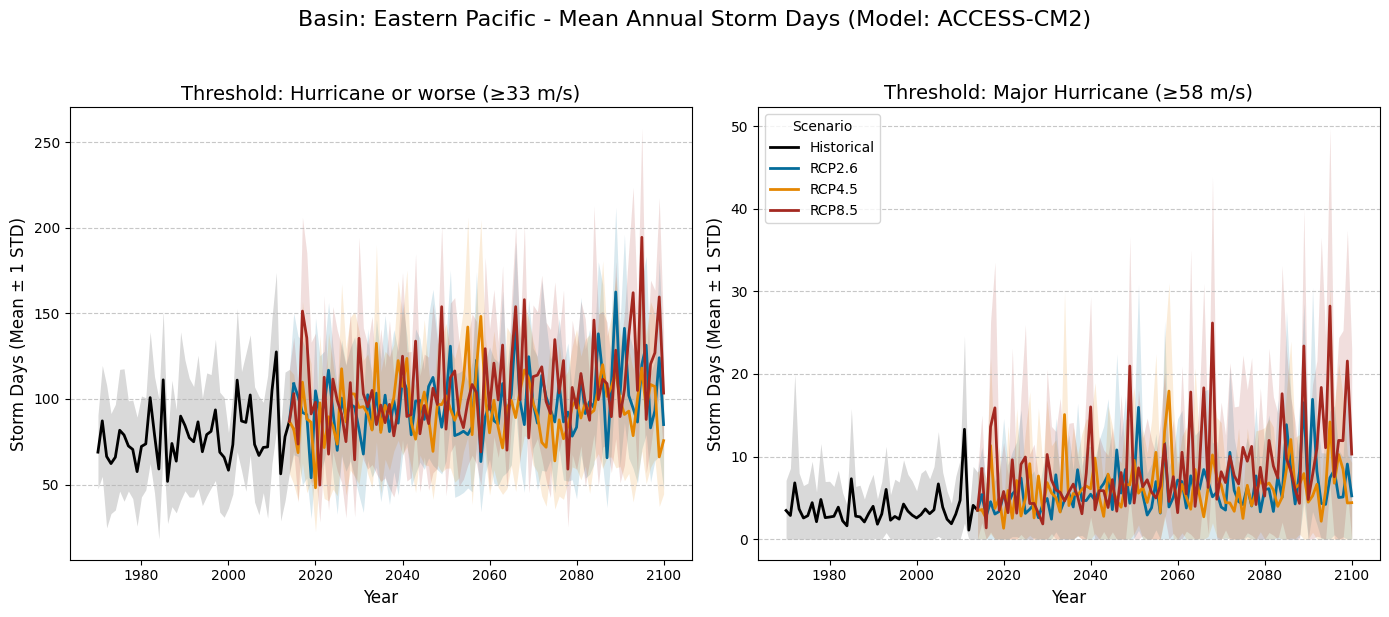

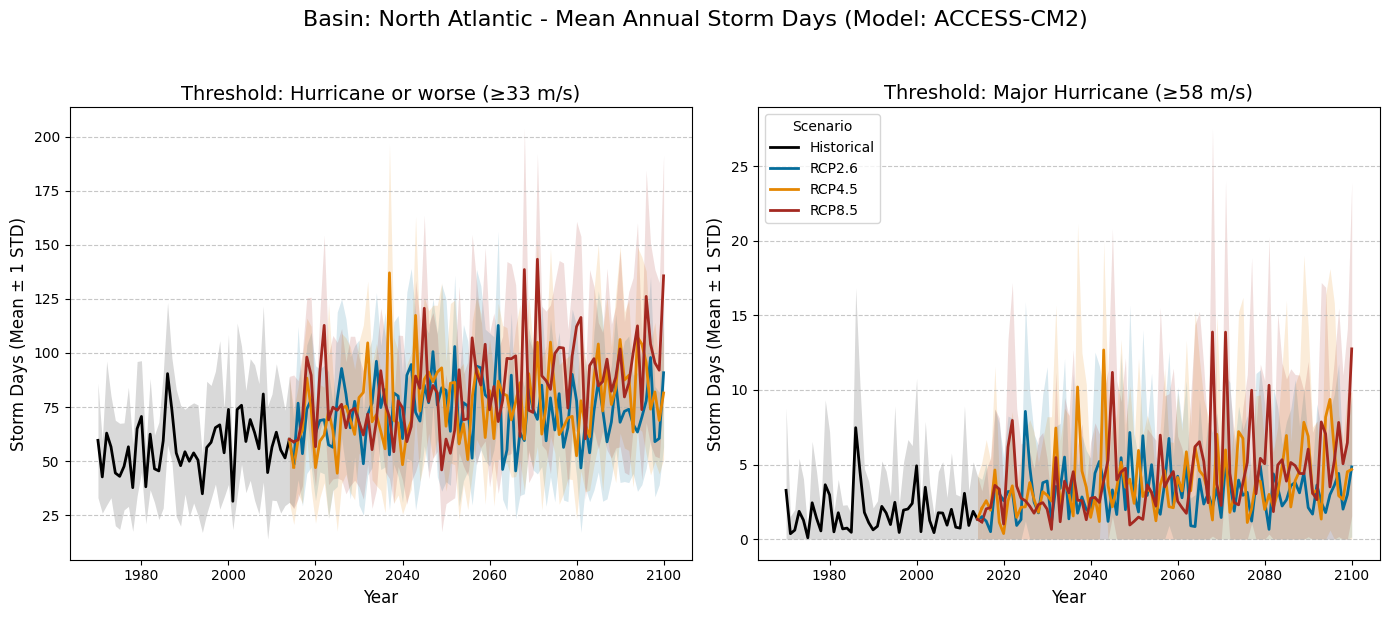

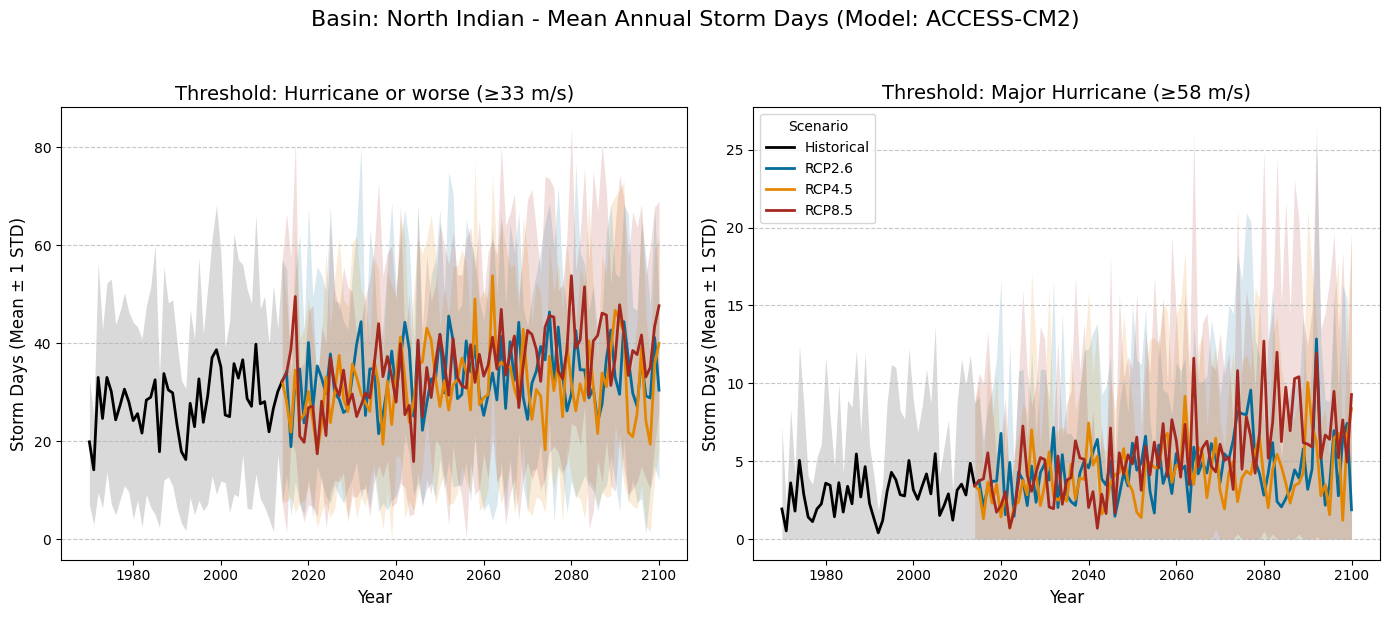

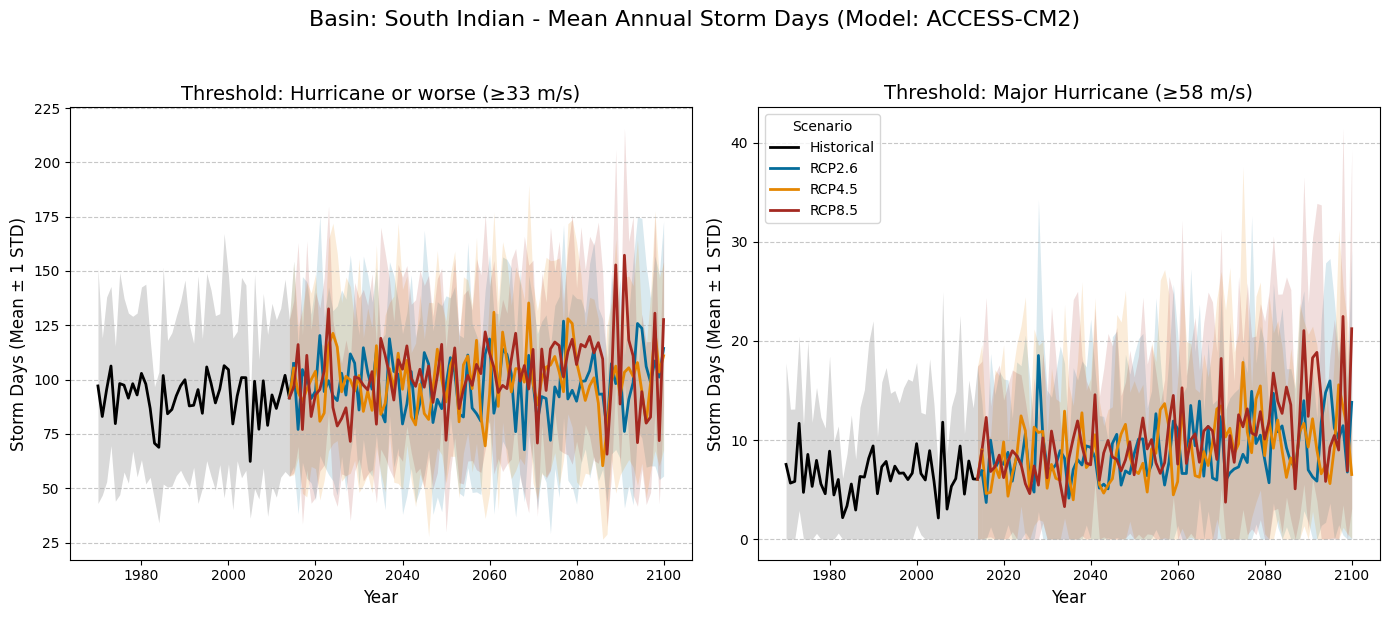

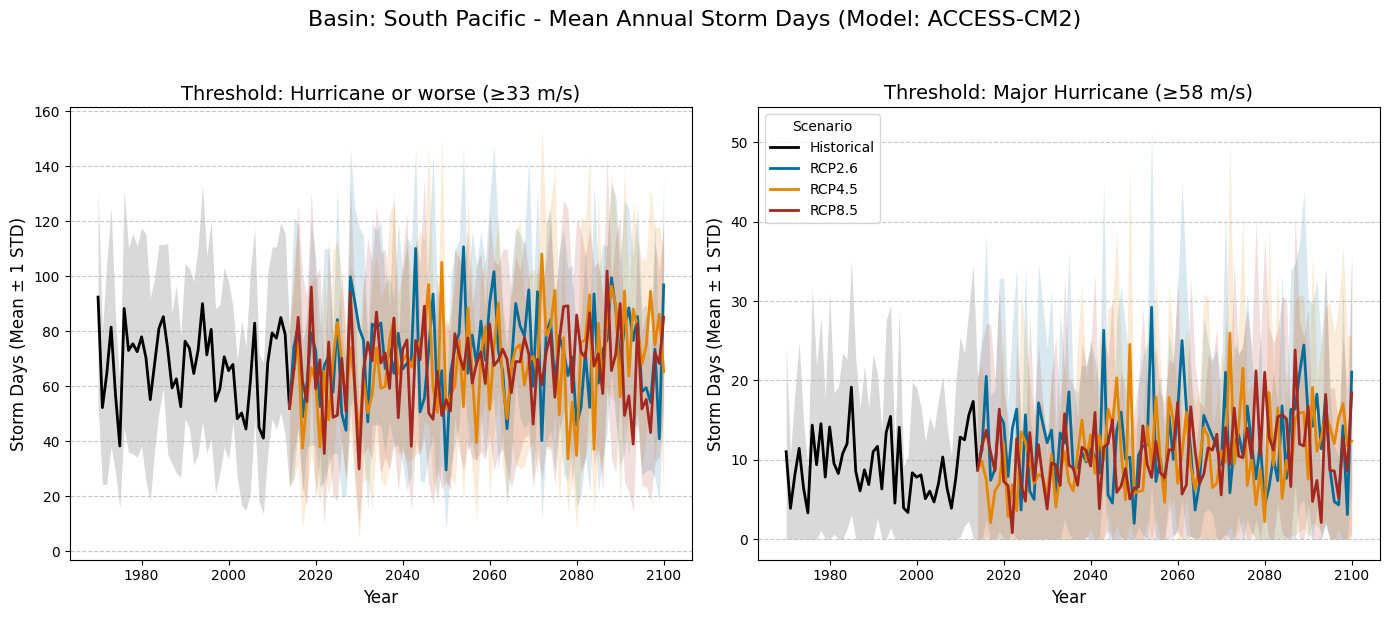

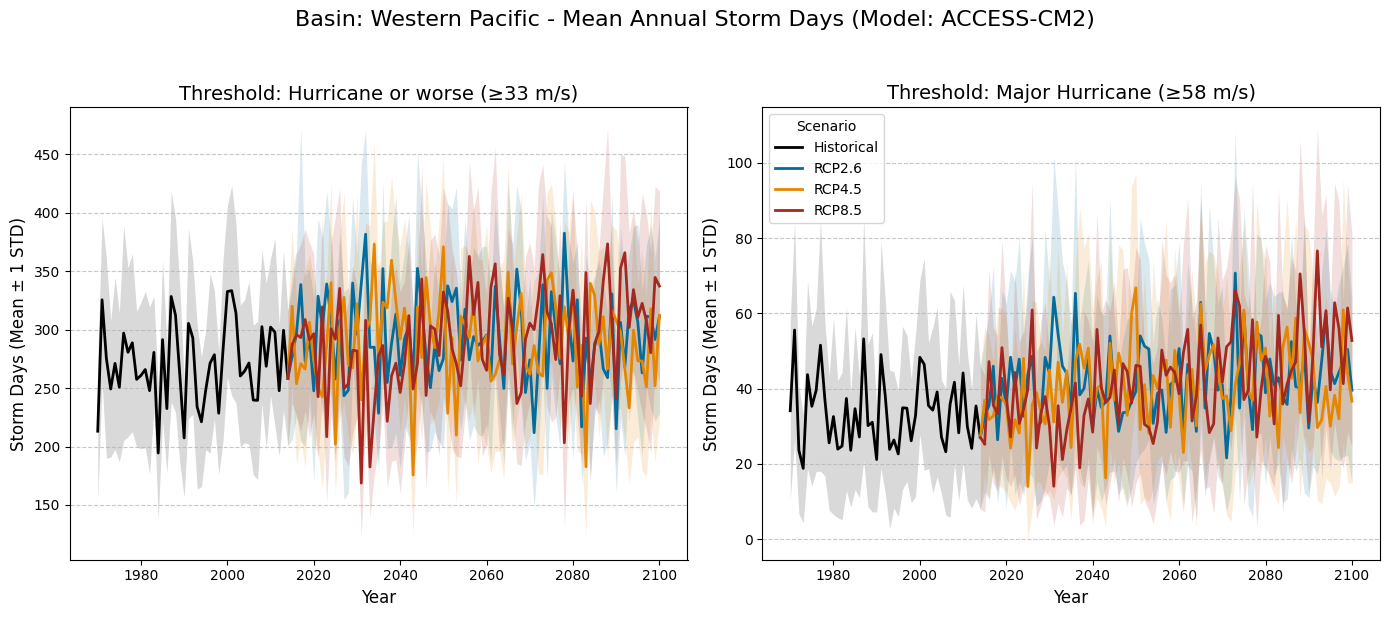

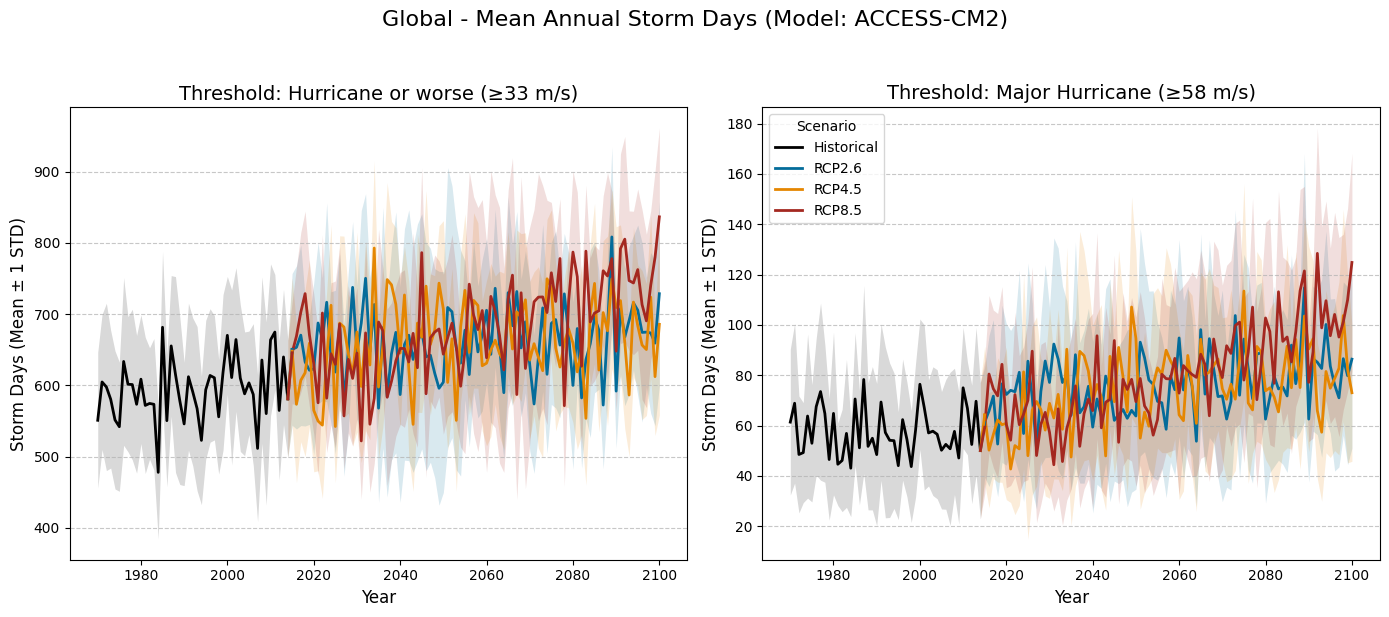

In [80]:
for basin in basin_dict:
    plot_annual_storm_metric_mean_std(final_df, target_basin=basin, metric='days')

In [32]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any

def calculate_cumulative_convergence(final_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the full suite of running stability diagnostics across all draws (k=1 to max_draws) 
    for every unique combination of model/scenario/year/basin/threshold.
    
    Includes: Running Mean, STD, CV, Relative Change in Mean, STD, and CV.

    Args:
        final_df: The long DataFrame containing raw storm metrics.

    Returns:
        A long DataFrame containing the running diagnostics.
    """
    
    group_dims: List[str] = ['model', 'scenario', 'year', 'basin', 'threshold']
    metrics: List[str] = ['count', 'days']
    
    df_sorted = final_df.sort_values(by=group_dims + ['draw'])
    stability_results: List[pd.DataFrame] = []
    
    grouped_data = df_sorted.groupby(group_dims)
    
    for group_key, group_df in grouped_data:
        
        for metric in metrics:
            values = group_df[metric].values
            N = len(values)
            
            # --- 1. Calculate Core Running Statistics (Mean, STD) ---
            cumulative_sum = np.cumsum(values)
            running_mean = cumulative_sum / np.arange(1, N + 1)
            running_std = [np.std(values[:i+1], ddof=1) if i > 0 else 0.0 for i in range(N)]
            
            # --- 2. Calculate Running CV (Coefficient of Variation) ---
            running_cv = np.divide(running_std, running_mean, 
                                   out=np.zeros_like(running_mean, dtype=float), 
                                   where=running_mean != 0)
            
            # --- 3. Calculate Relative Change Metrics (The new required logic) ---
            
            relative_change_mean = np.zeros_like(running_mean)
            relative_change_std = np.zeros_like(running_std, dtype=float)
            relative_change_cv = np.zeros_like(running_cv, dtype=float)
            
            for k in range(1, N):
                # Relative Change in Mean
                if np.abs(running_mean[k]) > 1e-9: 
                    relative_change_mean[k] = np.abs((running_mean[k] - running_mean[k - 1]) / running_mean[k])
                
                # Relative Change in STD
                if running_std[k - 1] > 1e-9: # Compare to previous STD
                    relative_change_std[k] = np.abs((running_std[k] - running_std[k - 1]) / running_std[k - 1])
                
                # Relative Change in CV
                if running_cv[k - 1] > 1e-9: # Compare to previous CV
                    relative_change_cv[k] = np.abs((running_cv[k] - running_cv[k - 1]) / running_cv[k - 1])

            # --- 4. Compile Results ---
            
            temp_df = pd.DataFrame({
                'draw': np.arange(1, N + 1),
                'metric_type': metric,
                'running_mean': running_mean,
                'running_std': running_std,
                'running_cv': running_cv,
                'relative_change_mean': relative_change_mean,
                'relative_change_std': relative_change_std,
                'relative_change_cv': relative_change_cv
            })
            
            for dim, value in zip(group_dims, group_key):
                temp_df[dim] = value
                
            stability_results.append(temp_df)

    stability_df = pd.concat(stability_results, ignore_index=True)

    return stability_df

In [33]:
# Assuming final_df is available from your processing script
convergence_report = calculate_cumulative_convergence(final_df)

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List

# --- Derived Variables ---
FUTURE_SCENARIOS: List[str] = ['ssp126', 'ssp245', 'ssp585']
SCENARIO_COLORS = {ssp: data['color'] for ssp, data in ssp_scenario_map.items()}

def plot_scenario_convergence_2x3(df_full_group: pd.DataFrame, target_metric: str = 'count'):
    """
    Generates a 2x3 plot grid comparing convergence across SSP scenarios, 
    using RCP labels and custom colors from ssp_scenario_map.
    """

    # Filter data down to only the target metric and required scenarios
    df = df_full_group[df_full_group['metric_type'] == target_metric]
    df = df[df['scenario'].isin(FUTURE_SCENARIOS)].copy()
    
    if df.empty:
        print(f"No data for target metric '{target_metric}' or scenarios {FUTURE_SCENARIOS}.")
        return

    # Extract single group keys for the main title
    model = df['model'].iloc[0]
    basin = df['basin'].iloc[0]
    year = df['year'].iloc[0]
    threshold = df['threshold'].iloc[0]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
    
    # ------------------- TITLES AND LAYOUT -------------------
    
    fig.suptitle(
        f'Ensemble Convergence Diagnostics: {model} / {basin} / {year} / {threshold} ({target_metric.title()})',
        fontsize=16
    )
    
    # Define common thresholds
    threshold_mean = 0.005  # 0.5%
    threshold_std_cv = 0.01  # 1.0%
    
    # ------------------- TOP ROW: Running Mean (Per Scenario) -------------------
    
    max_y = df['running_mean'].max() * 1.1 
    y_label_mean = f'Cumulative Average {target_metric.title()}'
    
    for i, ssp_scenario in enumerate(FUTURE_SCENARIOS):
        ax = axes[0, i]
        scenario_data = df[df['scenario'] == ssp_scenario]
        
        # Use custom color and RCP name
        color = SCENARIO_COLORS[ssp_scenario]
        rcp_label = ssp_scenario_map[ssp_scenario]['name']
        
        # Calculate bounds for shading
        lower_bound = scenario_data['running_mean'] - scenario_data['running_std']
        upper_bound = scenario_data['running_mean'] + scenario_data['running_std']

        # Plot Running Mean
        ax.plot(scenario_data['draw'], scenario_data['running_mean'], 
                label=r'Mean ($\mu_k$)', color=color, linewidth=2)
        
        # Plot Shaded Region (Mean +/- 1 STD)
        ax.fill_between(scenario_data['draw'], lower_bound, upper_bound, 
                        color=color, alpha=0.2, label=r'$\mu_k \pm 1 \sigma_k$')

        # Use the RCP name for the title
        ax.set_title(rcp_label, color=color, fontsize=12)
        ax.set_ylim(0, max_y)
        ax.grid(True, linestyle='--', alpha=0.6)

    # Set common Y-label for the top-left plot only
    axes[0, 0].set_ylabel(y_label_mean, fontsize=11)

    # ------------------- BOTTOM ROW: Relative Change (Overlaid) -------------------
    
    # Define axes for bottom row
    ax_mean_change, ax_std_change, ax_cv_change = axes[1, 0], axes[1, 1], axes[1, 2]
    
    # Define labels for bottom row
    y_label_change_mean = r'Rel. Change in Mean ($|\Delta \mu_k| / \mu_k$)'
    y_label_change_std = r'Rel. Change in STD ($|\Delta \sigma_k| / \sigma_{k-1}$)'
    y_label_change_cv = r'Rel. Change in CV ($|\Delta CV_k| / CV_{k-1}$)'

    # Apply common formatting and thresholds to all bottom plots
    for ax, y_label, threshold in zip(
        [ax_mean_change, ax_std_change, ax_cv_change],
        [y_label_change_mean, y_label_change_std, y_label_change_cv],
        [threshold_mean, threshold_std_cv, threshold_std_cv]
    ):
        ax.set_ylabel(y_label, fontsize=11)
        ax.axhline(threshold, color='gray', linestyle='--', linewidth=1, label=r'Target $\epsilon$')
        ax.set_xlabel('Number of Draws ($k$)', fontsize=10)
        ax.set_yscale('log')
        ax.grid(True, which="both", linestyle='--', alpha=0.6)
    
    # Loop to plot all three scenarios in the bottom row (overlaid)
    for ssp_scenario in FUTURE_SCENARIOS:
        scenario_data = df[df['scenario'] == ssp_scenario]
        color = SCENARIO_COLORS[ssp_scenario]
        rcp_label = ssp_scenario_map[ssp_scenario]['name']
        
        # Plot mean relative change
        ax_mean_change.plot(scenario_data['draw'], scenario_data['relative_change_mean'], 
                            label=rcp_label, color=color, linewidth=1.5)
        
        # Plot STD relative change
        ax_std_change.plot(scenario_data['draw'], scenario_data['relative_change_std'], 
                           label=rcp_label, color=color, linewidth=1.5)
                           
        # Plot CV relative change
        ax_cv_change.plot(scenario_data['draw'], scenario_data['relative_change_cv'], 
                          label=rcp_label, color=color, linewidth=1.5)
                          
    # Add a unified legend to the bottom-center panel
    ax_std_change.legend(title='Scenario', loc='upper right', fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

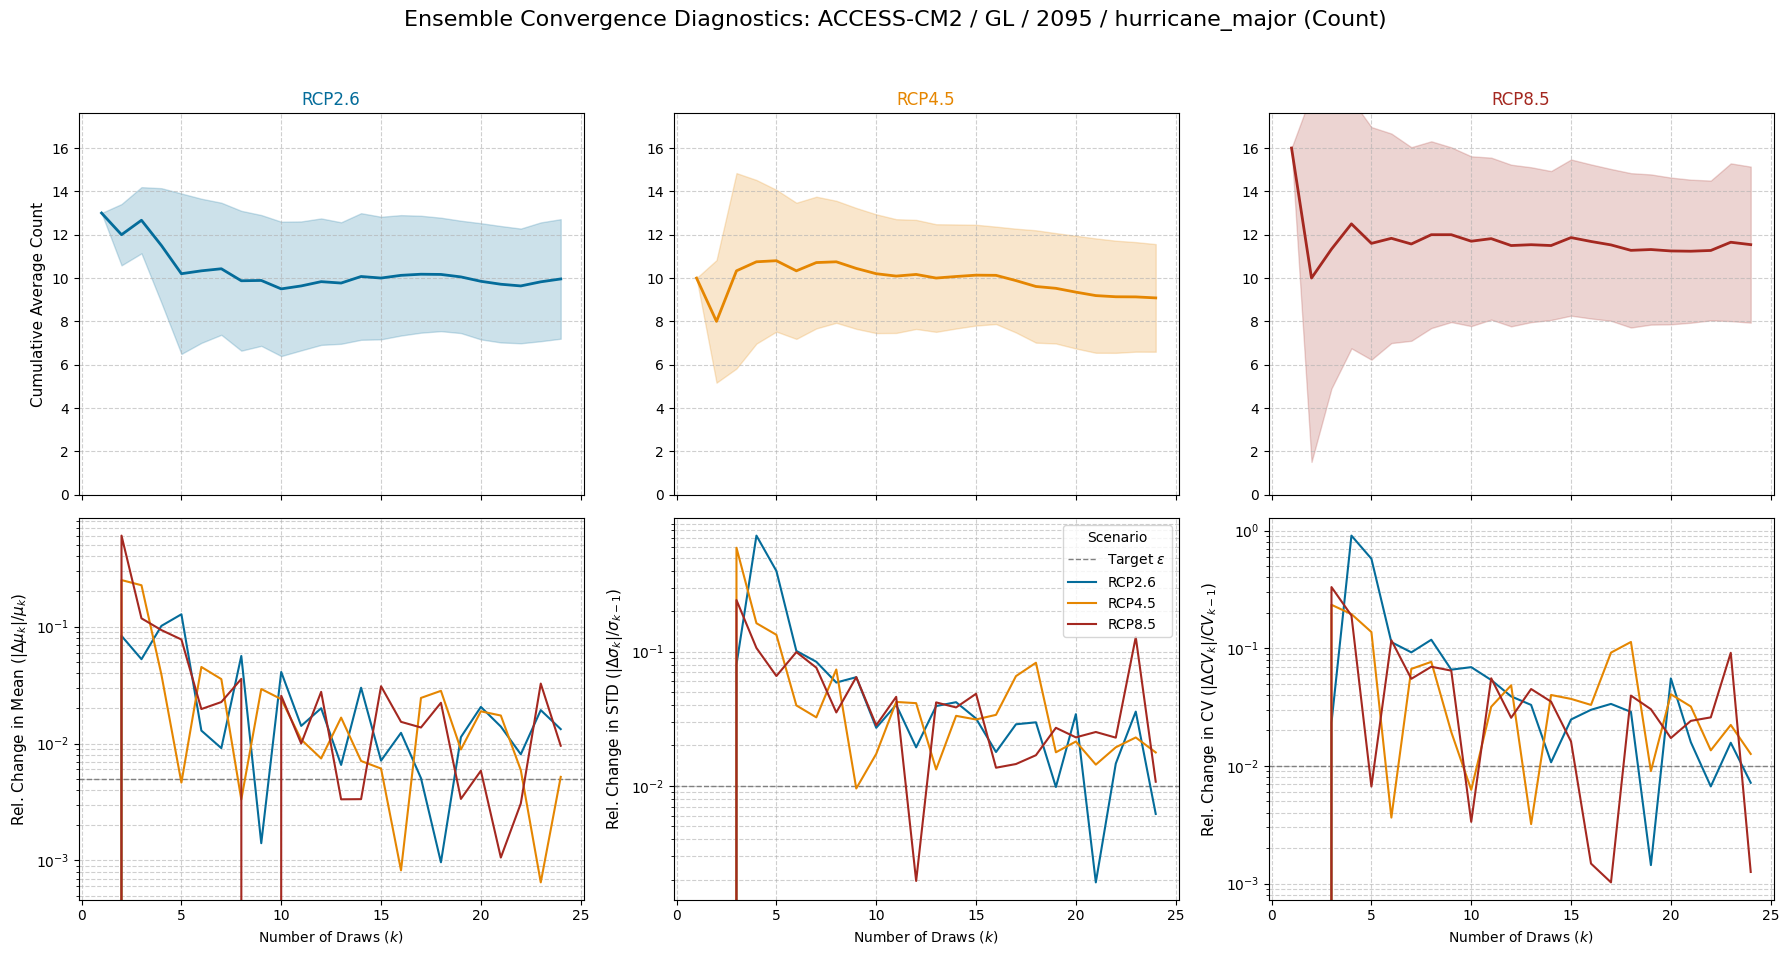

In [37]:
# --- Example of How to Run This (Using your specific filter) ---

# Step 1: Filter the full convergence report down to one group (25 rows)
sample_group = convergence_report[
    (convergence_report['model'] == 'ACCESS-CM2') & 
    (convergence_report['year'] == 2095) & 
    (convergence_report['basin'] == 'GL') &
    (convergence_report['metric_type'] == 'count') & 
    (convergence_report['threshold'] == 'hurricane_major') 
]

# Step 2: Pass the filtered data to the plotting function
plot_scenario_convergence_2x3(sample_group)

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming ssp_scenario_map, SCENARIO_COLORS, FUTURE_SCENARIOS are defined globally

def plot_final_summary_2x3(df_full_report: pd.DataFrame, target_metric: str = 'count', MAX_DRAWS: int = 25):
    """
    Generates the final 2x3 plot grid.
    
    The top row shares one Y-axis scale.
    The bottom row shares a separate Y-axis scale (logarithmic).
    
    Args:
        df_full_report: The full convergence report.
        target_metric: The metric to plot ('count' or 'days').
    """
    
    # 1. Filter Data to Final Draw and Target Metric
    
    df_final = df_full_report[
        (df_full_report['metric_type'] == target_metric) &
        (df_full_report['scenario'].isin(FUTURE_SCENARIOS))
    ].copy()

    # Extract metadata for the main title
    model = df_final['model'].iloc[0]
    basin = df_final['basin'].iloc[0]
    threshold = df_final['threshold'].iloc[0]

    # 2. Setup Plotting Environment
    # 🎯 Using sharey='row' ensures the Y-axis is shared across columns in the same row.
    # The two rows (index 0 and 1) will have independent Y-ranges.
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey='row') 
    
    fig.suptitle(
        f'Final Ensemble Comparison (Draw {MAX_DRAWS}) vs. Year: {model} / {basin} / {threshold} / {target_metric.title()}',
        fontsize=16
    )

    # Define labels and thresholds
    y_label_mean = f'Final Avg {target_metric.title()} ' + r'($\mu_{25} \pm 1\sigma$)'
    threshold_mean = 0.005 # 0.5%
    threshold_std_cv = 0.005  # 1.0%

    # ------------------- TOP ROW: Mean Estimate (Per Scenario) -------------------
    
    for i, ssp_scenario in enumerate(FUTURE_SCENARIOS):
        ax = axes[0, i]
        scenario_data = df_final[df_final['scenario'] == ssp_scenario].sort_values('year')
        # Print unique years for debugging
        
        color = SCENARIO_COLORS[ssp_scenario]
        rcp_label = ssp_scenario_map[ssp_scenario]['name']
        
        # Calculate bounds
        lower_bound = scenario_data['running_mean'] - scenario_data['running_std']
        upper_bound = scenario_data['running_mean'] + scenario_data['running_std']
        
        # Plot Mean and Uncertainty
        ax.plot(scenario_data['year'], scenario_data['running_mean'], 
                     label=r'$\mu_{25}$', color=color, linewidth=2)
        ax.fill_between(scenario_data['year'], lower_bound, upper_bound, 
                             color=color, alpha=0.15, label=r'$\pm 1 \sigma$')
                             
        ax.set_title(rcp_label, color=color, fontsize=12)
        
        # 🗑️ REMOVED: ax.set_ylim(0, max_y_mean) to allow Matplotlib to calculate the shared max Y-limit
        ax.grid(True, linestyle='--', alpha=0.6)

        if i == 0:
            ax.set_ylabel(y_label_mean, fontsize=11)
            ax.legend(loc='best', fontsize=9)

    # ------------------- BOTTOM ROW: Residual Relative Change (Per Metric, Overlaid) -------------------

    bottom_cols = [
        ('relative_change_mean', r'Rel. Change in Mean ($|\Delta \mu|/\mu$)'),
        ('relative_change_std', r'Rel. Change in STD ($|\Delta \sigma|/\sigma$)'),
        ('relative_change_cv', r'Rel. Change in CV ($|\Delta CV|/CV$)'),
    ]

    for i, (col, y_label_raw) in enumerate(bottom_cols):
        ax = axes[1, i]
        
        # Determine the threshold for the plot
        threshold = threshold_mean if col == 'relative_change_mean' else threshold_std_cv
        
        # Plot all scenarios overlaid
        lines = []
        for ssp_scenario in FUTURE_SCENARIOS:
            scenario_data = df_final[df_final['scenario'] == ssp_scenario].sort_values('year')
            color = SCENARIO_COLORS[ssp_scenario]
            rcp_label = ssp_scenario_map[ssp_scenario]['name']
            
            line, = ax.plot(scenario_data['year'], scenario_data[col], 
                            label=rcp_label, color=color, linewidth=2)
            lines.append(line)

        # Add convergence threshold
        ax.axhline(threshold, color='gray', linestyle='--', linewidth=1.5)
        
        ax.set_title(y_label_raw, fontsize=12)
        ax.set_xlabel('Year', fontsize=10)
        
        # Set the bottom row to log scale (note: this applies to the whole shared row)
        ax.set_yscale('log')
        ax.grid(True, which="both", linestyle='--', alpha=0.6)
        
        if i == 0:
            ax.set_ylabel('Residual Relative Change (Log Scale)', fontsize=11)
        elif i == 1:
            # Legend goes in the middle bottom plot
            ax.legend(title='Scenario', loc='upper right', fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [85]:
# Assuming convergence_report is available

# Define your specific target group (e.g., all years for this configuration)
TARGET_MODEL = 'ACCESS-CM2'
TARGET_BASIN = 'GL'
TARGET_THRESHOLD = 'hurricane_major'
TARGET_METRIC = 'count' # The metric to analyze

df_for_plot_grid = convergence_report[
    (convergence_report['model'] == TARGET_MODEL) & 
    (convergence_report['basin'] == TARGET_BASIN) &
    (convergence_report['threshold'] == TARGET_THRESHOLD) &
    (convergence_report['draw'] == NUM_DRAWS - 1)
].copy()


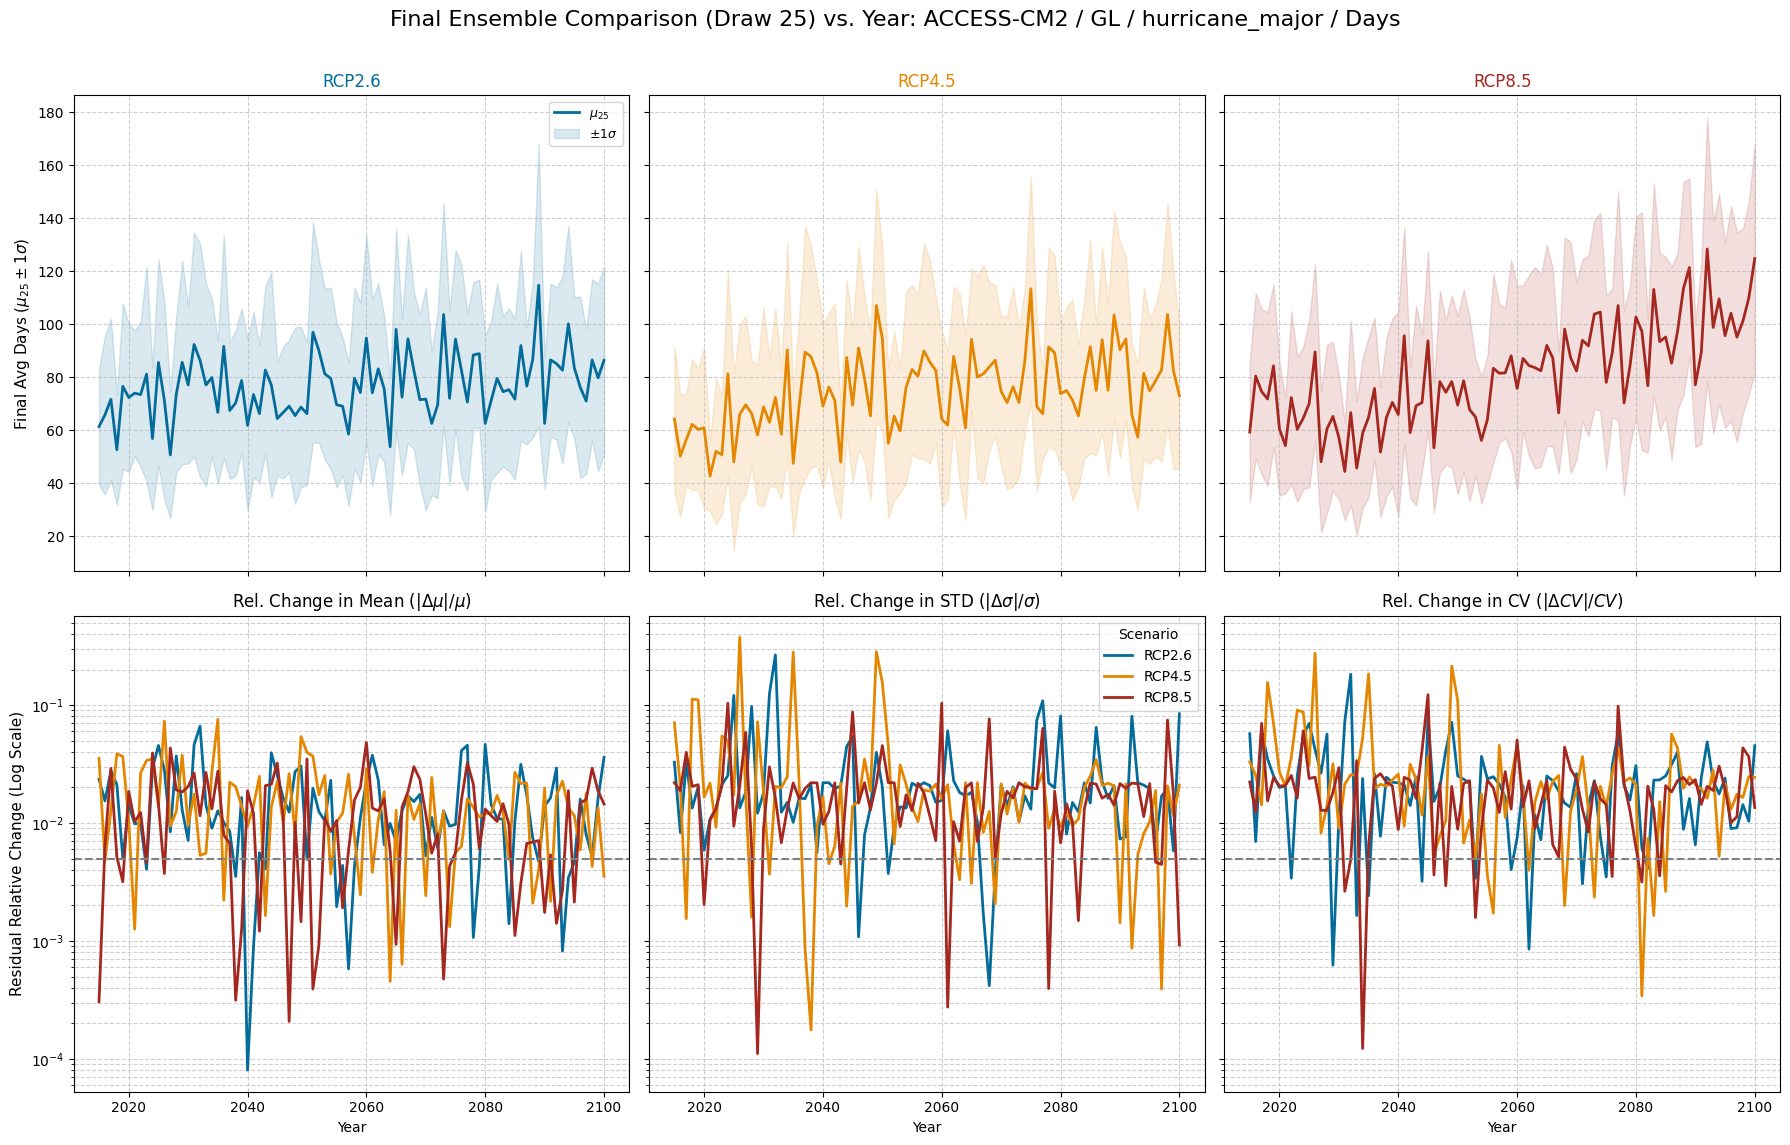

In [86]:
plot_final_summary_2x3(
    df_full_report=df_for_plot_grid, 
    target_metric='days'
)

In [81]:
import pandas as pd
import numpy as np

# Assuming 'convergence_report' is the DataFrame generated earlier
# and 'FUTURE_SCENARIOS' and 'HISTORICAL_SCENARIO' are defined.
# Using 'historical' and the SSPs as an example.
FUTURE_SCENARIOS = ['ssp126', 'ssp245', 'ssp585']
HISTORICAL_SCENARIO = 'historical'

# 1. Define the convergence metrics to analyze
relative_change_cols = [
    'relative_change_mean',
    'relative_change_std',
    'relative_change_cv'
]

# 2. Define the grouping dimensions (Model, Scenario, Basin, Metric Type)
group_dims = ['model', 'scenario', 'basin', 'metric_type']

# 3. Define the aggregation functions
agg_funcs = ['mean', 'std', 'min', 'median', 'max']

# 4. Perform the multi-level aggregation
stability_summary = convergence_report.groupby(group_dims, observed=True)[relative_change_cols].agg(agg_funcs)

# 5. Rename the columns for clarity (e.g., 'relative_change_mean_mean')
# This flattens the multi-index columns into a single index
stability_summary.columns = [
    f'{col}_{func}' for col, func in stability_summary.columns
]

# 6. Reset index to turn groups back into columns
stability_summary = stability_summary.reset_index()

# 7. Filter for future scenarios + historical (optional, but often clearer)
# We include all scenarios present in the report
# scenarios_to_report = [HISTORICAL_SCENARIO] + FUTURE_SCENARIOS
# stability_summary = stability_summary[stability_summary['scenario'].isin(scenarios_to_report)]

# 8. Sort and display the results
stability_summary = stability_summary.sort_values(by=['model', 'scenario', 'basin', 'metric_type'])

# Display the head of the resulting table
print("--- Ensemble Stability Summary (Aggregated over Years/Draws) ---")
print(stability_summary.head(10))
print(f"\nTotal Summary Rows Generated: {len(stability_summary)}")

--- Ensemble Stability Summary (Aggregated over Years/Draws) ---
        model    scenario basin metric_type  relative_change_mean_mean  \
0  ACCESS-CM2  historical    EP       count                   0.030775   
1  ACCESS-CM2  historical    EP        days                   0.056400   
2  ACCESS-CM2  historical    GL       count                   0.012169   
3  ACCESS-CM2  historical    GL        days                   0.020550   
4  ACCESS-CM2  historical    NA       count                   0.046630   
5  ACCESS-CM2  historical    NA        days                   0.059258   
6  ACCESS-CM2  historical    NI       count                   0.047554   
7  ACCESS-CM2  historical    NI        days                   0.071403   
8  ACCESS-CM2  historical    SI       count                   0.034568   
9  ACCESS-CM2  historical    SI        days                   0.051101   

   relative_change_mean_std  relative_change_mean_min  \
0                  0.093862                       0.0   
1     